# Model training for arabic character recognition app

## 1. Librairies and data

To make the code work, you need to download the data (csvTrain and csvTest images and labels) here :  https://www.kaggle.com/datasets/mloey1/ahcd1/data?select=Train%2BTest+Images+Matlab.mat

Then, import it in a folder named "data.  We can now load the librairies we need for this project.



In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import joblib
import pandas as pd
import cv2

#Deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

2024-11-11 10:46:24.089007: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-11 10:46:24.096881: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-11 10:46:24.118190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731318384.155565   43218 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731318384.166880   43218 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-11 10:46:24.203839: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

We cann now load the arabic letters datasets:

In [2]:
#Train dataset
X_train = pd.read_csv("data/csvTrainImages 13440x1024.csv", header=None)
X_train = X_train/255 #normalization between 0 and 1 to help models convergence and avoid overfitting
y_train = pd.read_csv("data/csvTrainLabel 13440x1.csv", header=None)
y_train = y_train -1 #labels start from 0

#Test dataset
X_test = pd.read_csv("data/csvTestImages 3360x1024.csv", header=None)
X_test = X_test/255 #same normalization as above
y_test = pd.read_csv("data/csvTestLabel 3360x1.csv", header=None)
y_test = y_test -1 

The following code plot an exemple of the training data. You can change the number "30" by any number between 0 and 13438.

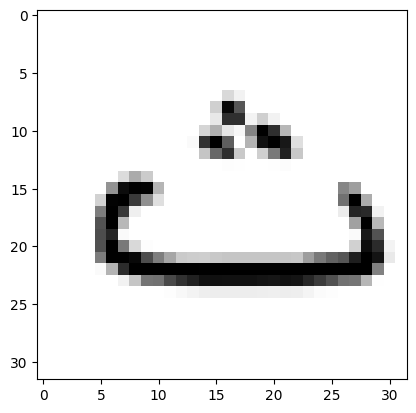

In [3]:
image_ex = np.array(X_train)[30].reshape(32, 32)
#reverse each column
image_ex= image_ex.T #to get the character as it is read

plt.imshow(image_ex, cmap='binary')

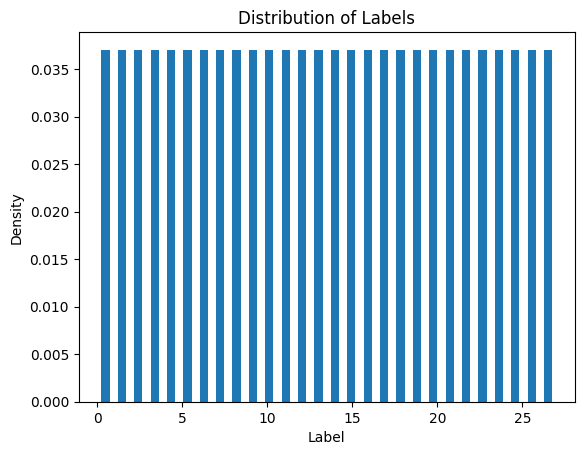

In [4]:
#Show the distribution of the labels
plt.hist(y_train, bins=28, range=(0, 27), rwidth=0.5, density=True)
plt.xlabel('Label')
plt.ylabel('Density')
plt.title('Distribution of Labels')
plt.show()

We can see that the dataset is perfectly balanced, as all things should be. This is because it comes directly from Kaggle.

## 2. A baseline model

Since the data set comes directly from kaggle, it is already clean (no duplicates or incomplete data) and ready to be use for training.

As a baseline for our letter classification task, we implemented a simple logistic regression model. Given the substantial size of our dataset, we opted for the Stochastic Average Gradient (SAG) solver. This choice was motivated by SAG's efficiency in handling large-scale optimization problems, as it combines the benefits of stochastic gradient descent with those of full gradient descent methods.

In [5]:
# Initialize the logistic regression model with SAG solver (Stochastic Average Gradient)
model = LogisticRegression(solver='sag', max_iter=1000, random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)

/home/fhakym/Documents/Github_projects/Arabic_letters_quizz_streamlit/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [6]:
# Make predictions on the test set
X_test
y_pred = model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.39


This model and its accuracy metric serve as a benchmark for evaluating the effectiveness of the subsequent Deep Learning model. 

Accuracy is an appropriate and reliable metric for this Arabic letter recognition task due to the balanced nature of the classes. In datasets with equal class representation, accuracy provides an unbiased assessment of the model's overall performance across all categories. It directly reflects the proportion of correct predictions (both true positives and true negatives) relative to the total number of cases examined.

Accuracy will thus serve as our primary evaluation metric throughout the remainder of this notebook. It provides a clear, consistent basis for comparing our Deep Learning model and the baseLine model.

## 3. Data preparation and Deep Learning model architecture

In [7]:
# Preprocess the data for deep learning
X_train_DL = np.array(X_train).reshape((X_train.shape[0], 32, 32, 1))
X_test_DL = np.array(X_test).reshape((X_test.shape[0], 32, 32, 1))

# Convert labels to categorical for compatibility with Keras
num_classes = 28
y_train_DL = to_categorical(y_train, num_classes)
y_test_cat_DL = to_categorical(y_test, num_classes)

The chosen model architecture is a Convolutional Neural Network (CNN) designed for image classification tasks (32x32 grayscale images).The model consists of three convolutional layers, each followed by max pooling, then a flatten layer, a dense layer with dropout for regularization, and finally an output layer. The use of ReLU activation and He uniform initialization in the convolutional and dense layers helps in training deep networks effectively.

In [8]:
# Define the CNN model architecture

model = Sequential([
    # First Convolutional Layer
    # 32 filters, 3x3 kernel size, ReLU activation, He uniform initialization
    # Input shape: 32x32 grayscale images (1 channel)
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(32, 32, 1)),
    
    # Max Pooling Layer
    # Reduces spatial dimensions by half
    MaxPooling2D((2, 2)),
    
    # Second Convolutional Layer
    # 64 filters, 3x3 kernel size, ReLU activation, He uniform initialization
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'),
    
    # Max Pooling Layer
    MaxPooling2D((2, 2)),
    
    # Third Convolutional Layer
    # 64 filters, 3x3 kernel size, ReLU activation, He uniform initialization
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'),
    
    # Flatten Layer
    # Converts the 2D feature maps to a 1D vector
    Flatten(),
    
    # First Dense Layer
    # 128 neurons, ReLU activation, He uniform initialization
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    
    # Dropout Layer
    # Helps prevent overfitting by randomly setting 50% of inputs to 0
    Dropout(0.5),
    
    # Output Layer
    # Number of neurons equals number of classes, Softmax activation for multi-class classification
    Dense(num_classes, activation='softmax')
])


/home/fhakym/Documents/Github_projects/Arabic_letters_quizz_streamlit/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-11 10:49:55.984269: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## 3. Model training and save

The given code compiles, trains, and evaluates a neural network model:

1. **Compile**: Uses the Adam optimizer with a learning rate of 0.001 and categorical crossentropy loss.
2. **Summary**: Displays the model architecture and parameters.
3. **Train**: Fits the model on training data for 20 epochs with a batch size of 32, using 10% of the data for validation.
4. **Evaluate**: Assesses model performance on test data and prints the test accuracy.


This process prepares the model for training and measures its effectiveness on unseen data. The proposed hyperparameters are standard, but could be optimized for better results.

In [9]:
# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

# Train the model
history = model.fit(X_train_DL, y_train_DL, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test_DL, y_test_cat_DL, verbose=0)
print(f'Test accuracy: {test_accuracy:.4f}')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 28)             │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,556 (744.36 KB)

 Trainable params: 190,556 (744.36 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.2064 - loss: 2.7408 - val_accuracy: 0.6749 - val_loss: 1.0289
Epoch 2/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.6489 - loss: 1.0592 - val_accuracy: 0.8140 - val_loss: 0.5701
Epoch 3/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.7841 - loss: 0.6485 - val_accuracy: 0.8467 - val_loss: 0.4808
Epoch 4/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.8400 - loss: 0.4869 - val_accuracy: 0.8631 - val_loss: 0.4233
Epoch 5/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.8734 - loss: 0.3765 - val_accuracy: 0.8839 - val_loss: 0.3614
Epoch 6/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.8977 - loss: 0.3073 - val_accuracy: 0.8891 - val_loss: 0.3104
Epoch 7/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.9156 - loss: 0.2579 - val_accuracy: 0.9107 - val_loss: 0.2984
Epoch 8/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.9278 - loss: 0.2210 - 

The model demonstrates significantly improved accuracy compared to the baseline. While there is potential for further enhancements, its current performance is satisfactory for our needs. We will now proceed to save the model for future use.

In [10]:
# Save the model
model.save('app/cnn_model.keras')

## 4. Model loading, evaluation, and test with visualisation on a image prediction

In [11]:
model = tf.keras.models.load_model('app/cnn_model.keras')

In [12]:
# Make predictions on test data
y_pred_DL = model.predict(X_test_DL)
y_pred_classes_DL = np.argmax(y_pred_DL, axis=1)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test_DL, y_test_cat_DL, verbose=0)
print(f'Test accuracy: {test_accuracy:.4f}')

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Test accuracy: 0.9512


Test prediction on a single image. You can replace the '3' by any number to test on a different image.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
0


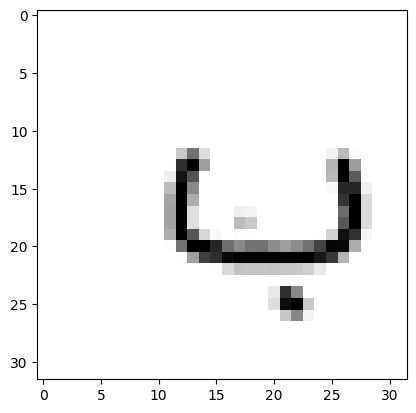

In [13]:
image_test = np.array(X_test)[3].reshape(32, 32, 1)
image_test = image_test.astype('float32') / 255

# Make predictions on the test image
y_pred_DL = model.predict(image_test.reshape(1, 32, 32, 1))
y_pred_classes_DL = np.argmax(y_pred_DL, axis=1)
print(y_pred_classes_DL[0])

# Plot the image
import matplotlib.pyplot as plt
image_test = image_test.T
plt.imshow(image_test.reshape(32, 32), cmap='binary')
plt.show()
